In [1]:
from decimal import Decimal
import matplotlib.pyplot as plt

import geomstats.backend as gs
import numpy as np
from nsimplices import *
from common import *
import scipy.stats as stats

gs.random.seed(2021)

In [2]:

base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'osteosarcoma'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
print(f"Will save figs to {figs_dir}")


# # 2. Dataset Description

# We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*, respectively representing a more agressive and a less agressive cancer.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).
# 
# Each cell comes from a raw image containing a set of cells, which was thresholded to generate binarized images.
# 
# <td>
#     <img src="figures/binarized_cells.png" width=400px />
# </td>
# 
# After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

# In[3]:


import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")


import pandas as pd

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']


ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)


def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds


def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    # print(f"old_length is: {old_length}, incr is: {incr}")
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        # print(f"i is: {i}, pos is: {pos}, index is: {index}, index after is: {(index + 1) % old_length}")
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma
Total number of cells : 650
['control' 'cytd' 'jasp']
['dlm8' 'dunn']
control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


In [3]:
k_sampling_points = 2000


cell_rand = cells[60]
print(cell_rand[0], cell_rand[-1], cell_rand[-2])
cell_interpolation = interpolate(cell_rand, k_sampling_points)


[ 854. -314.] [ 854. -315.] [ 855. -316.]


In [4]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

In [5]:
def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

In [6]:
def rotation_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    base_curve = gs.array(base_curve)

    # Rotation is done after projection, so the origin is removed
    total_space = DiscreteCurvesStartingAtOrigin(k_sampling_points=nb_sampling-1)
    total_space.fiber_bundle = SRVRotationBundle(total_space)

    print("finding optimal starting point")
    for shift in range(nb_sampling):
        print(shift)
        
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        print("before align")
        try:
            aligned = total_space.fiber_bundle.align(
                point=gs.array(reparametrized), base_point=base_curve
            )
        except:
            print(f"{shift} fails to align")
            pass
        print("after align")
        distances[shift] = np.linalg.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]

    print("rotate by the optimal starting point")
    aligned_curve = total_space.fiber_bundle.align(
        point=gs.array(reparametrized_min), base_point=base_curve
    )
    return aligned_curve



def align(point, base_point, rescale, rotation, reparameterization):
    """
    Align point and base_point via quotienting out translation, rescaling and reparameterization

    Right now we do not quotient out rotation since
    - Current geomstats does not support changing aligner for SRVRotationReparametrizationBundle
    - The base curve we chose is a unit circle, so quotienting out rotation won't affect the result too much
    """
    k_sampling_points = len(point)

    total_space = DiscreteCurvesStartingAtOrigin(k_sampling_points=k_sampling_points)
   
    
    # Quotient out translation 
    point = total_space.projection(point) 
    point = point - gs.mean(point, axis=0)

    base_point = total_space.projection(base_point)
    base_point = base_point - gs.mean(base_point, axis=0)

    # Quotient out rescaling
    if rescale:
        point = total_space.normalize(point) 
        base_point = total_space.normalize(base_point)
    
    # Quotient out rotation
    if rotation:
        point = rotation_align(point, base_point)

    # Quotient out reparameterization
    if reparameterization:
        aligner = DynamicProgrammingAligner(total_space)
        total_space.fiber_bundle = SRVReparametrizationBundle(total_space, aligner=aligner)
        point = total_space.fiber_bundle.align(point, base_point)
    return point

In [7]:
def check_duplicate(cell):
    """ 
    Return true if there are duplicate points in the cell
    """
    for i in range(cell.shape[0]-1):
        cur_coord = cell[i]
        next_coord = cell[i+1]
        if np.linalg.norm(cur_coord-next_coord) == 0:
            return True
        
    # Checking the last point vs the first poit
    if np.linalg.norm(cell[-1]-cell[0]) == 0:
        return True
    
    return False

In [8]:
BASE_CURVE = generate_ellipse(k_sampling_points)

data_folder = os.path.join(data_path, dataset_name, "aligned")

suffix = 'projection'
rescale = True
rotation = True
reparameterization = False
add_suffix = 'rotation_align'

if rescale:
    suffix += '_rescale'

if rotation:
    suffix += '_rotation'

if reparameterization:
    suffix += '_reparameterization'

if add_suffix is not None:
    suffix += "_"+add_suffix

data_folder = os.path.join(data_folder, suffix)

In [9]:
treatment = 'control' 
line = 'dlm8'
index = 51
k_sampling_points = 2000
cell = ds_proc[treatment][line][index][:k_sampling_points]
# cell[k_sampling_points-1] = (cell[0] + cell[k_sampling_points-2])/2
BASE_CURVE = generate_ellipse(k_sampling_points, a=12, b=5)

print(check_duplicate(cell))
aligned_cell = align(cell, BASE_CURVE, rescale, rotation, reparameterization)


False
finding optimal starting point
0
before align
after align
1
before align
1 fails to align
after align
2
before align
2 fails to align
after align
3
before align
3 fails to align
after align
4
before align
4 fails to align
after align
5
before align
5 fails to align
after align
6
before align
6 fails to align
after align
7
before align
7 fails to align
after align
8
before align
8 fails to align
after align
9
before align
9 fails to align
after align
10
before align
10 fails to align
after align
11
before align
11 fails to align
after align
12
before align
12 fails to align
after align
13
before align
13 fails to align
after align
14
before align
14 fails to align
after align
15
before align
15 fails to align
after align
16
before align
16 fails to align
after align
17
before align
17 fails to align
after align
18
before align
18 fails to align
after align
19
before align
19 fails to align
after align
20
before align
20 fails to align
after align
21
before align
21 fails to align


/home/wanxinli/miniconda3/envs/main@92c7a58/lib/python3.11/site-packages/geomstats/geometry/discrete_curves.py:300: RuntimeWarning: divide by zero encountered in divide
  "...ij,...i->...ij", velocity, 1.0 / gs.sqrt(pointwise_velocity_norm)


199 fails to align
after align
200
before align
200 fails to align
after align
201
before align
201 fails to align
after align
202
before align
202 fails to align
after align
203
before align
203 fails to align
after align
204
before align
204 fails to align
after align
205
before align
205 fails to align
after align
206
before align
206 fails to align
after align
207
before align
207 fails to align
after align
208
before align
208 fails to align
after align
209
before align
209 fails to align
after align
210
before align
210 fails to align
after align
211
before align
211 fails to align
after align
212
before align
212 fails to align
after align
213
before align
213 fails to align
after align
214
before align
214 fails to align
after align
215
before align
215 fails to align
after align
216
before align
216 fails to align
after align
217
before align
217 fails to align
after align
218
before align
218 fails to align
after align
219
before align
219 fails to align
after align
220
befor

In [10]:
print(cell[-1])
print(cell[0])
print(np.linalg.norm(cell[-1]-cell[0]))

[  74.9469986  -156.05299377]
[  75. -156.]
0.0749499094884721


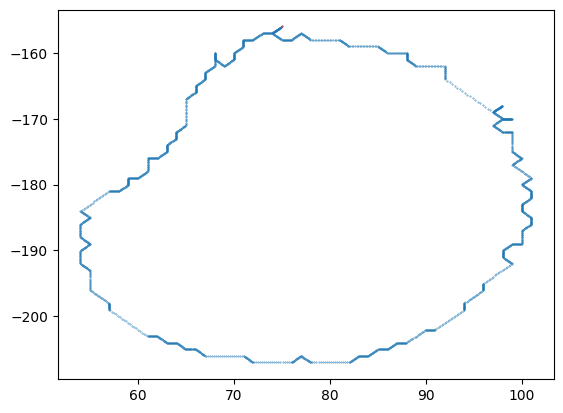

In [11]:
plt.scatter(cell[:, 0], cell[:, 1], s= 0.1)
plt.scatter(cell[0, 0], cell[0, 1], s= 0.1, c='red')

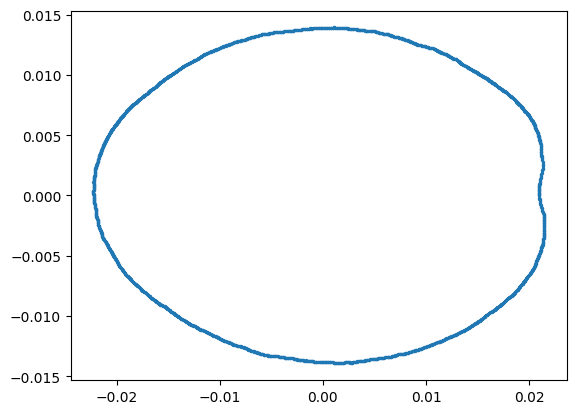

In [12]:
ref_path = "/home/wanxinli/dyn/dyn/datasets/osteosarcoma/aligned/projection_rescale_rotation_reparameterization_first_round/reference.txt"
cell = np.loadtxt(ref_path)
plt.scatter(cell[:, 0], cell[:, 1], s=2)

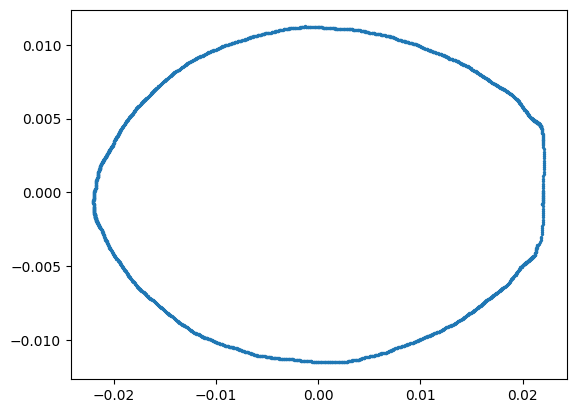

In [14]:
ref_path = "/home/wanxinli/dyn/dyn/datasets/breast_cancer/aligned/projection_rescale_rotation_reparameterization_first_round/reference.txt"
cell = np.loadtxt(ref_path)
plt.scatter(cell[:, 0], cell[:, 1], s=2)